# Location scale regression with smooth covariates 

In [1]:
import jax
import jax.numpy as jnp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Set path such that interpreter finds tigerpy
import sys
sys.path.append("..")

import tigerpy.model as tiger
import tigerpy.bbvi as bbvi
from tigerpy.distributions import MultivariateNormalDegenerate

# We use distributions and bijectors from tensorflow probability
import tensorflow_probability.substrates.jax.distributions as tfjd
import tensorflow_probability.substrates.jax.bijectors as tfjb

rng = np.random.default_rng(42)

# Load the data
df = pd.read_csv('../data/dbbmi.csv', sep=',')

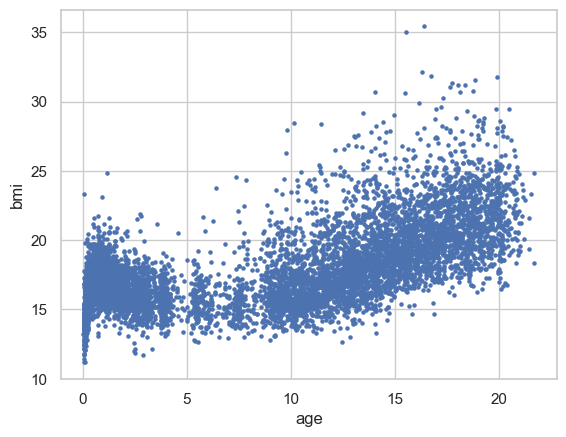

In [2]:
# Plot the data
sns.set_theme(style="whitegrid")
df.plot(kind = "scatter", x = "age", y = "bmi", s = 5)
plt.show()

In [3]:
# Define a model with intercept 
# Set up design matrix for loc
X = tiger.Obs(name="X_loc", intercept=True)
X.smooth(data=df["age"].to_numpy())
# If we combine fixed covariates and smooth covariates we need to center the the smooth effects first 
X.center()

# Set up design matrix for scale 
Z = tiger.Obs(name="Z_scale", intercept=True)
Z.smooth(data=df["age"].to_numpy())
# If we combine fixed covariates and smooth covariates we need to center the the smooth effects first 
Z.center()

# Linear Predictor for the location ----
# Fixed coefficents 
# Set up beta_fixed hyperparameters 
beta_fixed_loc = tiger.Hyper(0.0, name="beta_fixed_loc")
beta_fixed_scale = tiger.Hyper(100.0, name="beta_fixed_scale")

# Set up parameters
beta_fixed_dist = tiger.Dist(tfjd.Normal, loc=beta_fixed_loc, scale=beta_fixed_scale)
beta_fixed = tiger.Param(value=df["bmi"].to_numpy().mean(), distribution=beta_fixed_dist, name="beta_fixed")

# Smooth coefficients
# Set up hyperparameters for the beta_smooth_scale  
tau_a = tiger.Hyper(0.01, name="tau_a")
tau_b = tiger.Hyper(0.01, name="tau_b")
tau_dist = tiger.Dist(tfjd.InverseGamma, concentration=tau_a, scale=tau_b)
tau = tiger.Param(value=jnp.array([1.0]), distribution=tau_dist, param_space="positive", name="tau")

# Set up smooth coefficients with mvn degenerate 
# Set up hyperparameters
beta_smooth_loc = tiger.Hyper(np.zeros(X.smooth_dim_cent[0]), name="beta_smooth_loc")

# Set up parameters
beta_smooth_dist = tiger.Dist(MultivariateNormalDegenerate, loc=beta_smooth_loc, scale=tau, pen=X.smooth_pen_mat_cent[0])
beta_smooth = tiger.Param(value=np.zeros(X.smooth_dim_cent[0]), distribution=beta_smooth_dist, name="beta_smooth")

# Set up the linear predictor
lpred_loc = tiger.Lpred(obs=X, beta_fixed=beta_fixed, beta_smooth=beta_smooth)

# Linear Predictor for the scale ----
# Fixed coefficents 
# Set up beta_fixed hyperparameters 
gamma_fixed_loc = tiger.Hyper(0.0, name="gamma_fixed_loc")
gamma_fixed_scale = tiger.Hyper(100.0, name="gamma_fixed_scale")

# Set up parameters
gamma_fixed_dist = tiger.Dist(tfjd.Normal, loc=gamma_fixed_loc, scale=gamma_fixed_scale)
gamma_fixed = tiger.Param(value=np.log(df["bmi"].to_numpy().std()), distribution=gamma_fixed_dist, name="gamma_fixed")

# Smooth coefficients
# Set up hyperparameters for the beta_smooth_scale  
eta_a = tiger.Hyper(0.01, name="eta_a")
eta_b = tiger.Hyper(0.01, name="eta_b")
eta_dist = tiger.Dist(tfjd.InverseGamma, concentration=eta_a, scale=eta_b)
eta = tiger.Param(value=jnp.array([1.0]), distribution=eta_dist, param_space="positive", name="eta")

# Set up smooth coefficients with mvn degenerate 
# Set up hyperparameters
gamma_smooth_loc = tiger.Hyper(np.zeros(Z.smooth_dim_cent[0]), name="gamma_smooth_loc")

# Set up parameters
gamma_smooth_dist = tiger.Dist(MultivariateNormalDegenerate, loc=gamma_smooth_loc, scale=eta, pen=Z.smooth_pen_mat_cent[0])
gamma_smooth = tiger.Param(value=np.zeros(Z.smooth_dim_cent[0]), distribution=gamma_smooth_dist, name="gamma_smooth")

# ----
# Set up the linear predictor
lpred_scale = tiger.Lpred(obs=Z, gamma_fixed=gamma_fixed, gamma_smooth=gamma_smooth, function=jnp.exp)

# Set up response distribution
response_dist = tiger.Dist(tfjd.Normal, loc=lpred_loc, scale=lpred_scale)
m = tiger.Model(response=df["bmi"].to_numpy(), distribution=response_dist)

## Test log-prob and setup the graph 

In [4]:
m.log_prob

Array(-18183.508, dtype=float32)

In [5]:
m.log_prior

Array(-49.613403, dtype=float32)

In [6]:
graph = tiger.ModelGraph(model=m)
graph.build_graph()

In [7]:
graph.collect_logpriors()

Array(-49.613407, dtype=float32)

In [8]:
graph.logprob()

Array(-18183.508, dtype=float32)

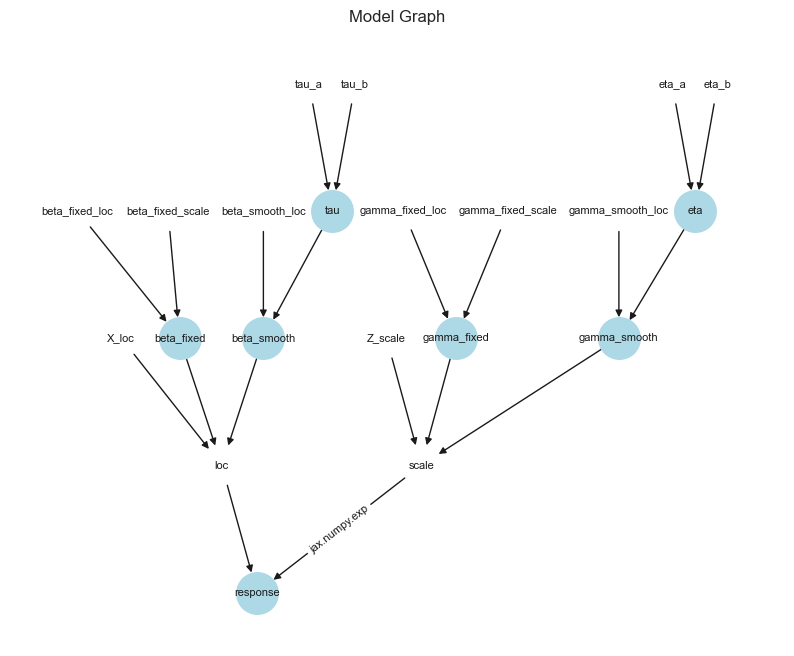

In [9]:
graph.visualize_graph()

## Test where the NA's come from 

In [10]:
import tigerpy.distributions.mvn as mvn
q = bbvi.Bbvi(graph=graph)
key = jax.random.PRNGKey(27)
key, *subkeys = jax.random.split(key, len(q.init_var_params)+1)

In [11]:
# Obtain the variational parameters 
# Parameters location 
loc_beta_fixed, lower_tri_beta_fixed = q.init_var_params["beta_fixed"]["loc"], q.init_var_params["beta_fixed"]["lower_tri"]
loc_beta_smooth, lower_tri_beta_smooth = q.init_var_params["beta_smooth"]["loc"], q.init_var_params["beta_smooth"]["lower_tri"]
loc_tau, lower_tri_tau= q.init_var_params["tau"]["loc"], q.init_var_params["tau"]["lower_tri"]

# Parameters scale
loc_gamma_fixed, lower_tri_gamma_fixed = q.init_var_params["gamma_fixed"]["loc"], q.init_var_params["gamma_fixed"]["lower_tri"]
loc_gamma_smooth, lower_tri_gamma_smooth = q.init_var_params["gamma_smooth"]["loc"], q.init_var_params["gamma_smooth"]["lower_tri"]
loc_eta, lower_tri_eta = q.init_var_params["eta"]["loc"], q.init_var_params["eta"]["lower_tri"]


In [12]:
# Obtain samples from the variational distributions
# Parameters location
samples_beta_fixed = mvn.mvn_precision_chol_sample(loc=loc_beta_fixed, precision_matrix_chol=lower_tri_beta_fixed, key=subkeys[0], S=64)
samples_beta_smooth = mvn.mvn_precision_chol_sample(loc=loc_beta_smooth, precision_matrix_chol=lower_tri_beta_smooth, key=subkeys[1], S=64)
samples_tau = mvn.mvn_precision_chol_sample(loc=loc_tau, precision_matrix_chol=lower_tri_tau, key=subkeys[2], S=64)

# Parameters scale 
samples_gamma_fixed = mvn.mvn_precision_chol_sample(loc=loc_gamma_fixed, precision_matrix_chol=lower_tri_gamma_fixed, key=subkeys[3], S=64)
samples_gamma_smooth = mvn.mvn_precision_chol_sample(loc=loc_gamma_smooth, precision_matrix_chol=lower_tri_gamma_smooth, key=subkeys[4], S=64)
samples_eta = mvn.mvn_precision_chol_sample(loc=loc_eta, precision_matrix_chol=lower_tri_eta, key=subkeys[5], S=64)

In [13]:
# Store all the variational samples in a dict
test_samples = {"beta_fixed": samples_beta_fixed,
                "beta_smooth": samples_beta_smooth,
                "tau": jnp.exp(samples_tau),
                "gamma_fixed": samples_gamma_fixed,
                "gamma_smooth": samples_gamma_smooth,
                "eta": jnp.exp(samples_eta)}

In [14]:
jnp.log(df["bmi"].to_numpy().std())

Array(1.0671998, dtype=float32)

In [15]:
for kw, value in test_samples.items():
    print(jnp.mean(value, axis=0))

[18.250137]
[ 0.18041912 -0.17759414 -0.01105324  0.04873802 -0.01233988  0.16652505
  0.15328854  0.27443665  0.14211816  0.00464203  0.1563411  -0.04232728
  0.01314852 -0.2597431   0.04689287 -0.1501235   0.19508782 -0.06865343
 -0.0133689 ]
[1.0155115]
[1.0493159]
[-0.00586101  0.00469897  0.00043366 -0.00992262  0.01726486 -0.00430268
  0.00614567  0.00403654  0.01019055 -0.01270801  0.00346192 -0.00253064
  0.02954823  0.00498628  0.003747    0.02283442  0.00731117 -0.00514648
 -0.013905  ]
[1.0045741]


In [16]:
batch_idx = jax.random.choice(key, q.num_obs, (32,), replace=False)

In [17]:
data_new = jax.tree_map(lambda x: x[batch_idx], q.data)

In [18]:
graph.logprob()

Array(-18183.508, dtype=float32)

In [19]:
graph.collect_logpriors()

Array(-49.613407, dtype=float32)

In [20]:
q.mc_logprob(data_new,  test_samples, q.num_obs)

Array(-19381.422, dtype=float32)

In [21]:
-2.3446405e+06

-2344640.5

In [22]:
q.lower_bound(q.init_var_params, 
              data_new,
              num_obs=q.num_obs,
              num_var_samples=64,
              key=key)

Array(19444.531, dtype=float32)

## Inference with Bbvi

In [23]:
q = bbvi.Bbvi(graph=graph)

In [32]:
import optax
schedule = optax.warmup_cosine_decay_schedule(
    init_value=0.,
    peak_value=0.2,
    warmup_steps=100,
    decay_steps=2_000,
    end_value=0.001,
)

In [24]:
q.run_bbvi(step_size=0.01,
           threshold=1e-2,
           key_int=4,
           batch_size=1000,
           num_var_samples=64,
           chunk_size=50,
           epochs=2500)

(Array(-14719.435, dtype=float32, weak_type=True),
 {'beta_fixed': {'loc': Array([18.026041], dtype=float32),
   'cov': Array([[0.00137299]], dtype=float32)},
  'tau': {'loc': Array([0.16395809], dtype=float32),
   'cov': Array([[0.02744101]], dtype=float32)},
  'gamma_fixed': {'loc': Array([0.67612803], dtype=float32),
   'cov': Array([[0.00060281]], dtype=float32)},
  'eta': {'loc': Array([-1.5551058], dtype=float32),
   'cov': Array([[0.02887897]], dtype=float32)},
  'beta_smooth': {'loc': Array([-2.7914953 , -2.56935   , -1.3069116 , -2.5607195 , -2.4370527 ,
          -2.0726895 , -1.6477665 , -1.401405  , -1.186293  , -0.572084  ,
          -0.09242134,  0.43648022,  1.1658281 ,  1.5585113 ,  2.1686366 ,
           2.8339446 ,  3.3606617 ,  3.6537242 ,  3.870933  ], dtype=float32),
   'cov': Array([[ 6.86516240e-03,  1.27543067e-03, -5.99020766e-03,
            1.89256785e-03,  5.98292158e-04,  1.65953112e-04,
           -9.44421117e-05,  1.02363562e-03,  8.25210998e-04,
        

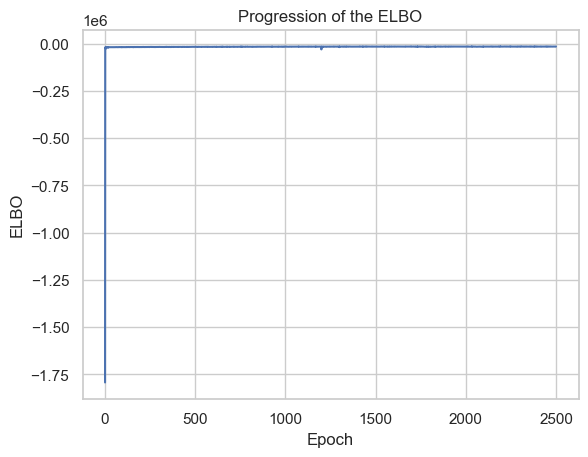

In [25]:
q.plot_elbo()

## Visualize the regression line 

In [26]:
b = q.trans_var_params["beta_smooth"]["loc"]
b

Array([-2.7914953 , -2.56935   , -1.3069116 , -2.5607195 , -2.4370527 ,
       -2.0726895 , -1.6477665 , -1.401405  , -1.186293  , -0.572084  ,
       -0.09242134,  0.43648022,  1.1658281 ,  1.5585113 ,  2.1686366 ,
        2.8339446 ,  3.3606617 ,  3.6537242 ,  3.870933  ], dtype=float32)

In [27]:
g = q.trans_var_params["gamma_smooth"]["loc"]
g

Array([-0.5582087 , -0.21590333, -0.4169733 , -0.22572719, -0.06117623,
       -0.00167115, -0.00883719,  0.05200956,  0.13676688,  0.1828199 ,
        0.17920259,  0.26966563,  0.3093332 ,  0.18128645,  0.24167548,
        0.27045617,  0.46543497,  0.1986536 ,  0.07930657], dtype=float32)

In [28]:
Z.design_matrix

array([[  1.        ,  -1.226038  ,   0.9633438 , ...,  -0.99010634,
          0.66402423,  -0.8032893 ],
       [  1.        ,  -1.20652   ,   0.9364594 , ...,  -0.98112977,
          0.65800405,  -0.7960065 ],
       [  1.        ,  -1.20652   ,   0.9364594 , ...,  -0.98112977,
          0.65800405,  -0.7960065 ],
       ...,
       [  1.        ,   0.590157  ,  -0.44971567, ...,  14.062937  ,
        -18.65899   ,   9.341964  ],
       [  1.        ,   0.6761211 ,  -0.51522267, ...,  16.29679   ,
        -21.400085  ,  10.471391  ],
       [  1.        ,   0.6890274 ,  -0.5250577 , ...,  16.63356   ,
        -21.811132  ,  10.639808  ]], dtype=float32)

In [29]:
# Location
# for fixed and smooth terms
b_fixed = q.trans_var_params["beta_fixed"]["loc"]
b_smooth = q.trans_var_params["beta_smooth"]["loc"]
b = jnp.concatenate((b_fixed, b_smooth))
y_loc = X.design_matrix @ b
# Scale 
g_fixed = q.trans_var_params["gamma_fixed"]["loc"]
g_smooth = q.trans_var_params["gamma_smooth"]["loc"]
g = jnp.concatenate((g_fixed, g_smooth))
y_scale = jnp.exp(Z.design_matrix @ g)


In [30]:
y_scale

Array([ 1.4654875,  1.4641109,  1.4641109, ..., 18.858694 , 27.355988 ,
       28.940308 ], dtype=float32)

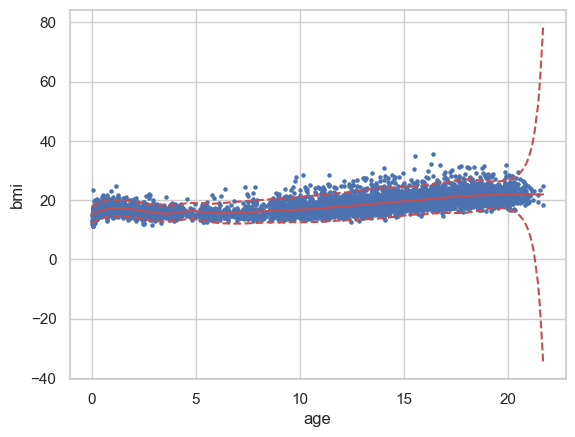

In [31]:
# plot the data
fig, ax = plt.subplots()

df.plot(kind="scatter", x="age", y="bmi", s=5, ax=ax)
ax.plot(df["age"].to_numpy(), y_loc, color = "r")
ax.plot(df["age"].to_numpy(), y_loc - 1.96*y_scale, color = "r", linestyle="--")
ax.plot(df["age"].to_numpy(), y_loc + 1.96*y_scale, color = "r", linestyle="--")
plt.show()

NameError: name 's' is not defined

In [ ]:
m = jnp.exp(tau + s/2)

In [ ]:
1 / (m ** 2)

Array([[1.8865789]], dtype=float32)